In [ ]:
  !pip install spacy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!ls "/content/drive/My Drive/DEBI/nlp/Group_project/Assignment_2"
# !python3 "/content/drive/Shared with me/Group_project/Assignment_2/cluster_evaluate.py"

python3: can't open file '/content/drive/Shared with me/Group_project/Assignment_2/cluster_evaluate.py': [Errno 2] No such file or directory


In [ ]:
# from google.colab import files
# src = list(files.upload().values())[0]  ## Here you see a pop-up command to upload the file from your local directory
# open('cluster_evaluate.py','wb').write(src)
from cluster_evaluate import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm as tq
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer, TfidfTransformer
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, linkage
from sklearn.metrics import silhouette_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def book_pagination(book, book_name, author, title):
    """
    Partitioning(pagination) of the book to take each 100 word with the label/book_name for each partition.
    """
    tokenized_words=nltk.word_tokenize(book)
    tokenized_words = [w for w in tokenized_words if not w.lower() in stop_words]

    offset = 0
    pages = []
    for i in range(1, min(int(np.floor(len(tokenized_words)/150.0)), 200)):
        limit = i*150
        pages.append({'book_name': book_name,
                      'partition': " ".join(tokenized_words[offset:limit]),
                      'author': author,
                      'title': title})
        offset = limit 
    return pages

def clean_text(text):
  ## 1. Lowercase the text
  text = text.lower() 

  ## 2. Remove Punctuations
  text = text.translate(str.maketrans('', '', string.punctuation)) 
  
  ## 3. Tokenize all the words
  words = nltk.word_tokenize(text)

  ## 4. Remove stopwords and word digits
  clean_text = " ".join([ w for w in words if w.isalnum() ])
  clean_text = clean_text.replace("\t", ' ')
  # clean_text = " ".join([ w for w in words if w.isalnum() and (w not in stop_words)  ])
  return clean_text

In [ ]:
import json

In [ ]:
books = [
         {'file': 'austen-emma.txt' , 'url': "https://www.gutenberg.org/ebooks/158",
          'author': 'Jane Austen', 'genre': 'Fiction', 'title': 'Emma'},
         
         {'file': 'blake-poems.txt', 'url':'https://www.gutenberg.org/ebooks/574',
          'author': 'William Blake', 'genre': 'Poetry', 'title': 'Poems of William Blake'},
         
         {'file': 'shakespeare-hamlet.txt', 'url':'https://www.gutenberg.org/ebooks/1787',
          'author': 'William Shakespeare', 'genre': 'Drama', 'title': 'Hamlet'},
         
         {'file': 'carroll-alice.txt', 'url':'https://www.gutenberg.org/ebooks/35688',
         'author': 'Lewis Carroll and Alice Gerstenberg', 'genre': 'Fantasy Drama', 'title': 'Alice in Wonderland'},
         
         {'file': 'edgeworth-parents.txt', 'url':'https://www.gutenberg.org/ebooks/36132',
          'author': 'Maria Edgeworth', 'genre': "Children's stories", 'title': "The Parent's Assistant; Or, Stories for Children"}]

with open('books.json', 'w') as jf:
  json.dump(books, jf)

In [ ]:
books = pd.read_json('books.json')

In [ ]:
book_pages = []

for ind,bk in tq(books.iterrows(), total= books.shape[0]):
  book = nltk.corpus.gutenberg.raw(bk['file'])
  clean_book = clean_text(book) ## Regex to clean the text and tokenize it
  mydict=book_pagination(clean_book, bk['file'].split('.txt')[0], bk['author'], bk['title'])
  book_pages+=mydict

books_df = pd.DataFrame(book_pages)

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


In [ ]:
books_df.head()

,book_name,partition,author,title
0,austen-emma,emma jane austen 1816 volume chapter emma wood...,Jane Austen,Emma
1,austen-emma,liked highly esteeming miss taylors judgment d...,Jane Austen,Emma
2,austen-emma,promoted match black mornings work want miss t...,Jane Austen,Emma
3,austen-emma,mile miss taylor house advantages natural dome...,Jane Austen,Emma
4,austen-emma,lawn shrubberies name really belong afforded e...,Jane Austen,Emma


In [ ]:
tfidf_vec = TfidfVectorizer()
tfidf = tfidf_vec.fit_transform(books_df.partition)

tfidf_vec_bigram = TfidfVectorizer(ngram_range=(2, 2))
tfidf_bigram = tfidf_vec_bigram.fit_transform(books_df.partition)

bow_vec = CountVectorizer()
bow = bow_vec.fit_transform(books_df.partition)

bow_vec_bigram = CountVectorizer(ngram_range=(2,2))
bow_bigram = bow_vec_bigram.fit_transform(books_df.partition)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist_tfidf = 1- cosine_similarity(tfidf)
dist_tfidf = dist_tfidf - dist_tfidf.min() # get rid of some pesky floating point errors that give neg. distance
len(dist_tfidf)

716

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


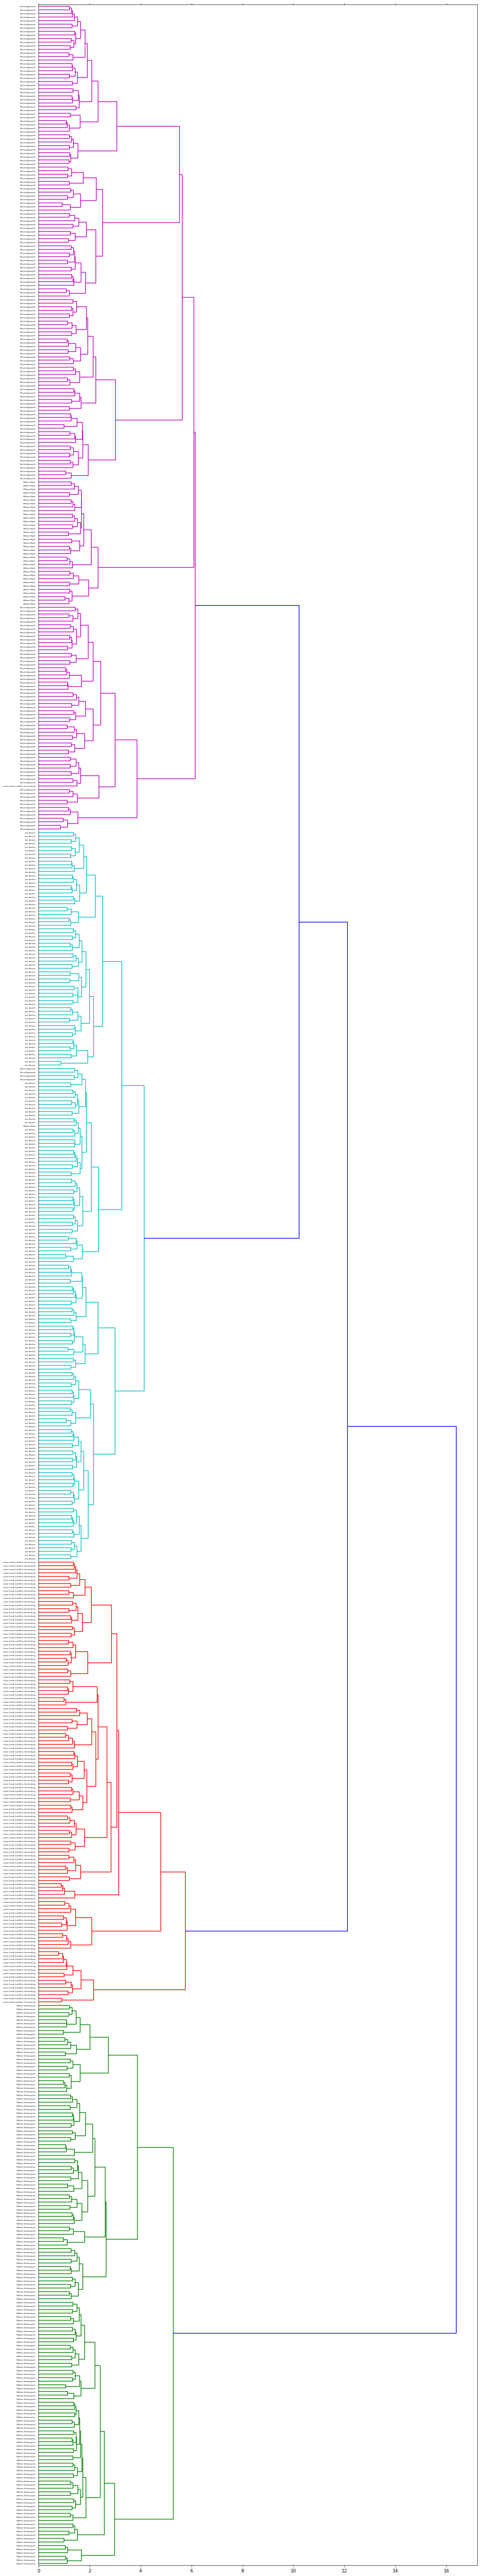

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
MAX_TITLE_LEN = 48
linkage_matrix_tfidf = ward(dist_tfidf) #define the linkage_matrix using ward clustering pre-computed distances
MAX_COPHENETIC_DIST = max(linkage_matrix_tfidf[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix_tfidf, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=books_df.author.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

In [ ]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: 0.03271856267578276
Silhouette score with 3 clusters: 0.02897998773797783
Silhouette score with 4 clusters: 0.03514699911085971
Silhouette score with 5 clusters: 0.037593489219300814
Silhouette score with 6 clusters: 0.04003345406482812
Silhouette score with 7 clusters: 0.03707948231946701
Silhouette score with 8 clusters: 0.03985200057709794
Silhouette score with 9 clusters: 0.04337894643763712
Silhouette score with 10 clusters: 0.03880737961107687
Silhouette score with 11 clusters: 0.03955048558514979
Silhouette score with 12 clusters: 0.033114278463355594
Silhouette score with 13 clusters: 0.028515909892244017
Silhouette score with 14 clusters: 0.029329729611001956
Silhouette score with 15 clusters: 0.029534811093420658
Silhouette score with 16 clusters: 0.029409545977138404
Silhouette score with 17 clusters: 0.03064140391744986
Silhouette score with 18 clusters: 0.02992837864777805
Silhouette score with 19 clusters: 0.029871440925702902
Silhouette 

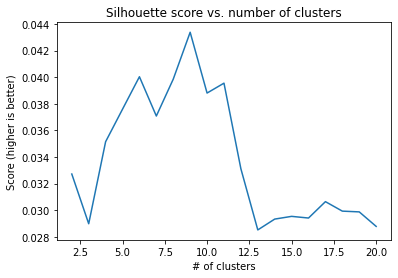

In [ ]:
Scores_tfidf = silhouette_k(dist_tfidf, linkage_matrix_tfidf)

In [ ]:
# create clusters
hc_tfidf = AgglomerativeClustering(n_clusters=9, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
hc_tfidf.fit_predict(dist_tfidf)


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
label_encoder = LabelEncoder()
labels_coded = label_encoder.fit_transform(books_df["title"])

## Bag Of Words

In [ ]:
dist_BOW = 1 - cosine_similarity(bow)
dist_BOW = dist_BOW - dist_BOW.min()

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


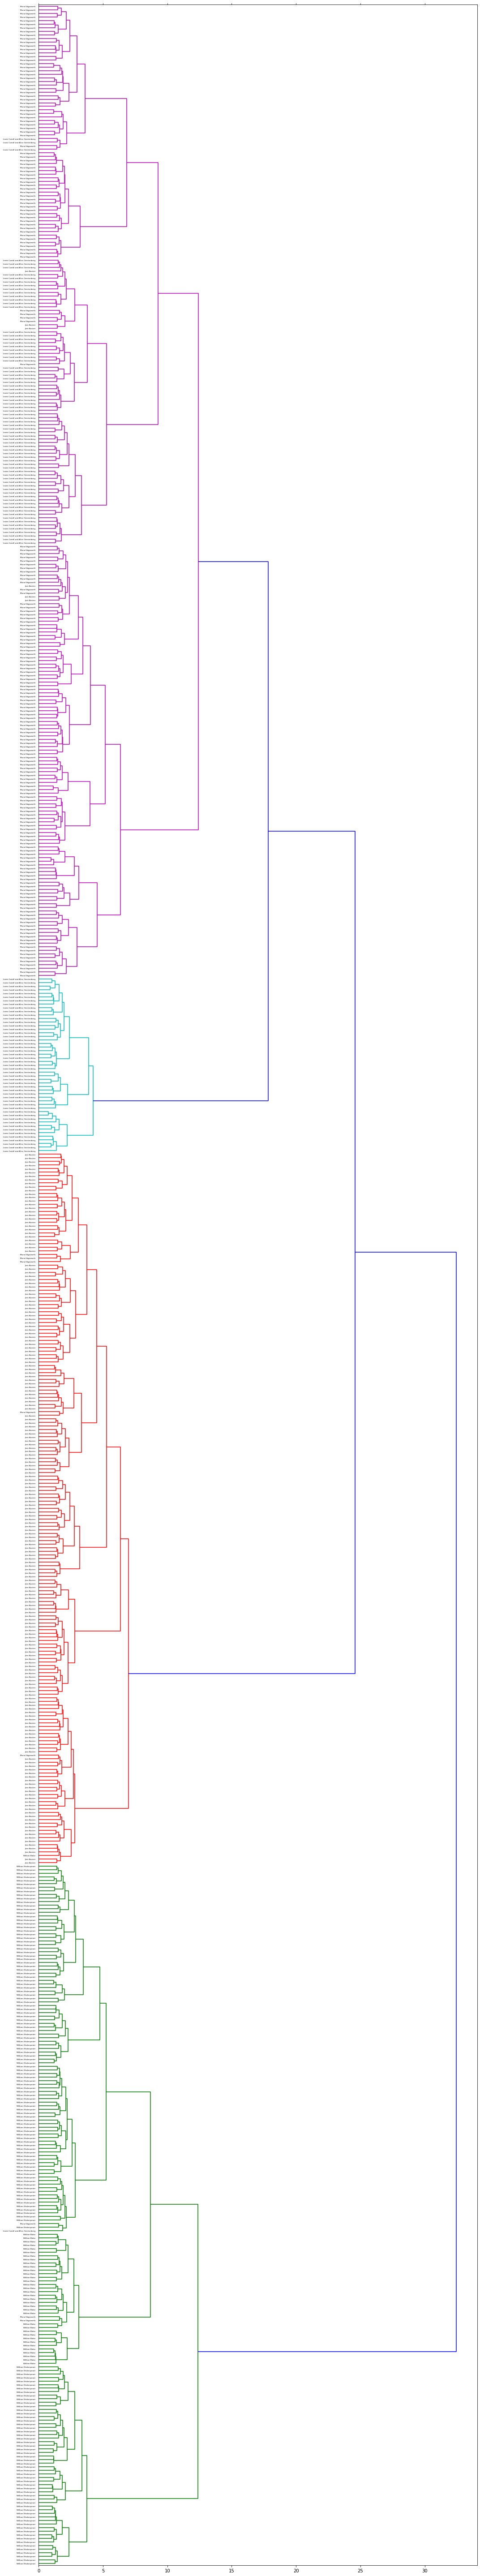

In [ ]:
linkage_matrix_BOW = ward(dist_BOW) #define the linkage_matrix using ward clustering pre-computed distances

MAX_COPHENETIC_DIST = max(linkage_matrix_BOW[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix_BOW, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=books_df.author.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all1.png', dpi=300)

Silhouette score with 2 clusters: 0.06687699008723297
Silhouette score with 3 clusters: 0.059258083414358724
Silhouette score with 4 clusters: 0.03477620932817398
Silhouette score with 5 clusters: 0.03589906114535928
Silhouette score with 6 clusters: 0.030805154464866924
Silhouette score with 7 clusters: 0.03571935266828707
Silhouette score with 8 clusters: 0.039191444833506506
Silhouette score with 9 clusters: 0.0306390590340638
Silhouette score with 10 clusters: 0.033331606800642254
Silhouette score with 11 clusters: 0.0357187377222906
Silhouette score with 12 clusters: 0.02633323225374726
Silhouette score with 13 clusters: 0.0231623098997436
Silhouette score with 14 clusters: 0.020832979682616434
Silhouette score with 15 clusters: 0.019568899003031655
Silhouette score with 16 clusters: 0.02176250344836803
Silhouette score with 17 clusters: 0.020451459540011194
Silhouette score with 18 clusters: 0.022305518061669024
Silhouette score with 19 clusters: 0.02332023869930446
Silhouette sc

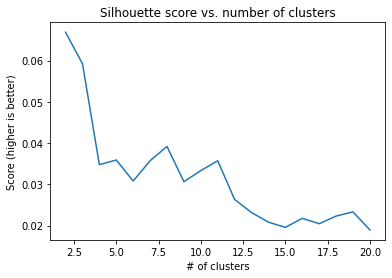

In [ ]:
scores_BOW = silhouette_k(dist_BOW, linkage_matrix_BOW)

In [ ]:
# create clusters
hc_BOW = AgglomerativeClustering(n_clusters=8, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
hc_BOW.fit_predict(dist_BOW)

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5, 6,
       6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 6,

In [ ]:
get_clusters_label(hc_tfidf.labels_ ,books_df.author)

actual_labels
clusters actual_labels                                     
0        William Shakespeare                     100.000000
1        Jane Austen                              97.549020
         Maria Edgeworth                           1.960784
         William Blake                             0.490196
2        Lewis Carroll and Alice Gerstenberg     100.000000
3        Maria Edgeworth                         100.000000
4        Maria Edgeworth                          98.412698
         Lewis Carroll and Alice Gerstenberg       1.587302
5        William Blake                           100.000000
6        Lewis Carroll and Alice Gerstenberg     100.000000
7        Maria Edgeworth                         100.000000
8        Maria Edgeworth                         100.000000

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(hc_tfidf.labels_ ,books_df.author)))

,cluster,label,percentage
0,0,William Shakespeare,100.000000
1,1,Jane Austen,97.549020
2,2,Lewis Carroll and Alice Gerstenberg,100.000000
3,3,Maria Edgeworth,100.000000
4,4,Maria Edgeworth,98.412698
5,5,William Blake,100.000000
6,6,Lewis Carroll and Alice Gerstenberg,100.000000
7,7,Maria Edgeworth,100.000000
8,8,Maria Edgeworth,100.000000


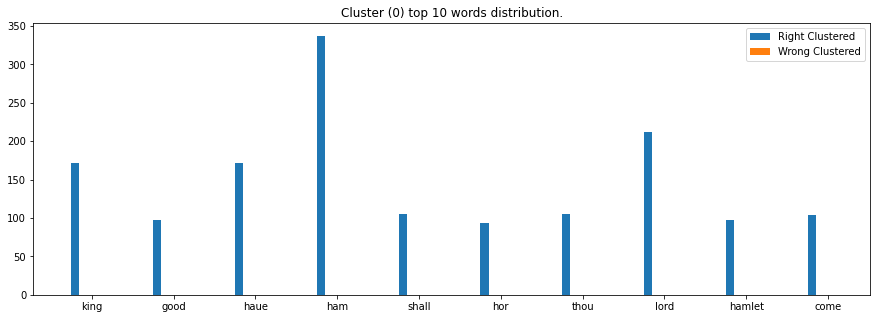

Top 10 words in the right clustered
 [('ham', 337), ('lord', 212), ('king', 171), ('haue', 171), ('thou', 105), ('shall', 105), ('come', 104), ('hamlet', 98), ('good', 98), ('hor', 93)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




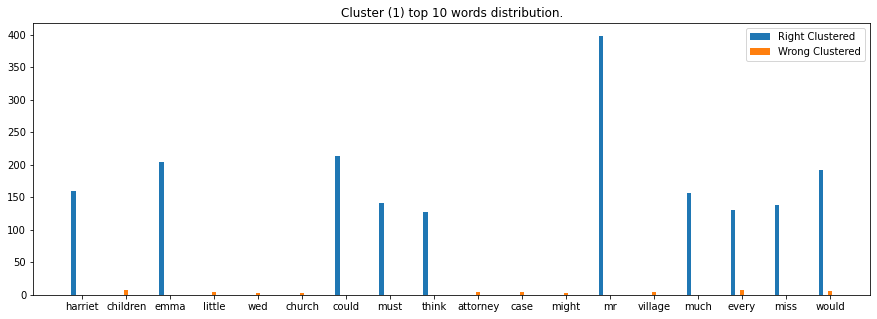

Top 10 words in the right clustered
 [('mr', 398), ('could', 213), ('emma', 204), ('would', 192), ('harriet', 160), ('much', 157), ('must', 141), ('miss', 138), ('every', 131), ('think', 127)]

Top 10 words in the wrong clustered
 [('children', 7), ('every', 7), ('would', 6), ('little', 5), ('village', 5), ('attorney', 4), ('case', 4), ('wed', 3), ('church', 3), ('might', 3)]

Found 2 words in both right and wrong clustered top words [('every', 7), ('would', 6)]




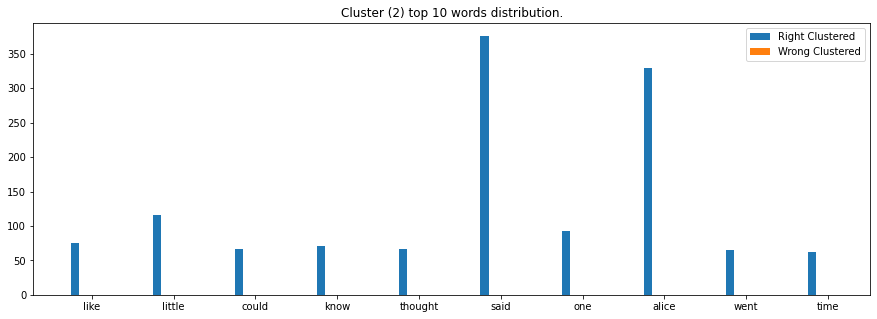

Top 10 words in the right clustered
 [('said', 376), ('alice', 329), ('little', 116), ('one', 92), ('like', 75), ('know', 71), ('thought', 67), ('could', 66), ('went', 65), ('time', 62)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




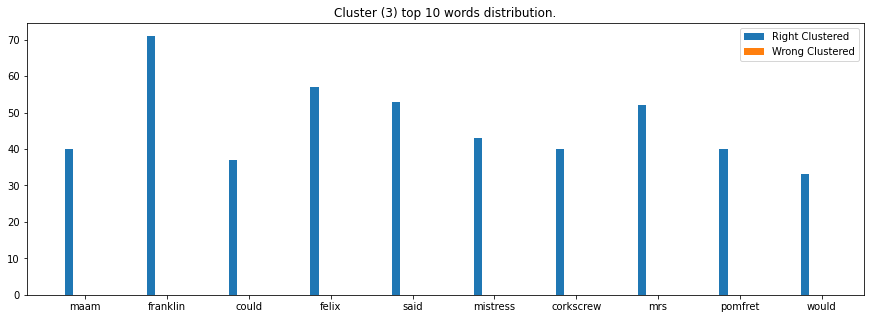

Top 10 words in the right clustered
 [('franklin', 71), ('felix', 57), ('said', 53), ('mrs', 52), ('mistress', 43), ('pomfret', 40), ('maam', 40), ('corkscrew', 40), ('could', 37), ('would', 33)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




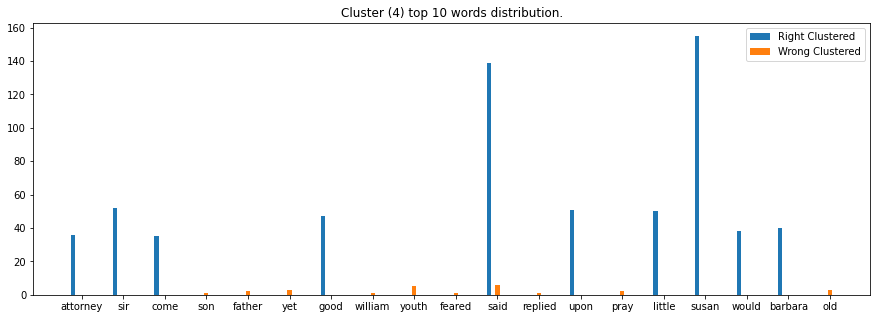

Top 10 words in the right clustered
 [('susan', 155), ('said', 139), ('sir', 52), ('upon', 51), ('little', 50), ('good', 47), ('barbara', 40), ('would', 38), ('attorney', 36), ('come', 35)]

Top 10 words in the wrong clustered
 [('said', 6), ('youth', 5), ('old', 3), ('yet', 3), ('pray', 2), ('father', 2), ('william', 1), ('replied', 1), ('son', 1), ('feared', 1)]

Found 1 words in both right and wrong clustered top words [('said', 6)]




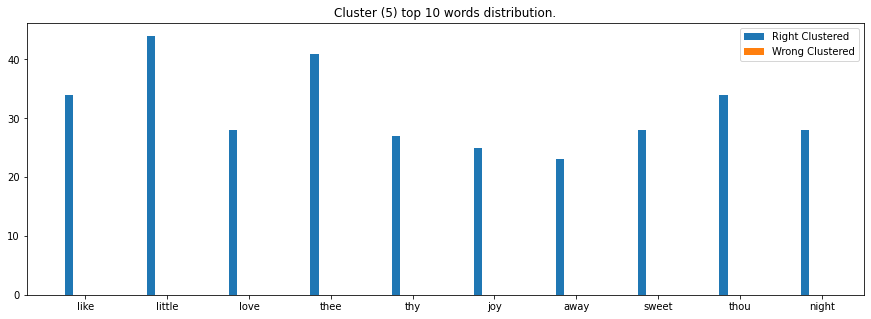

Top 10 words in the right clustered
 [('little', 44), ('thee', 41), ('like', 34), ('thou', 34), ('sweet', 28), ('love', 28), ('night', 28), ('thy', 27), ('joy', 25), ('away', 23)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




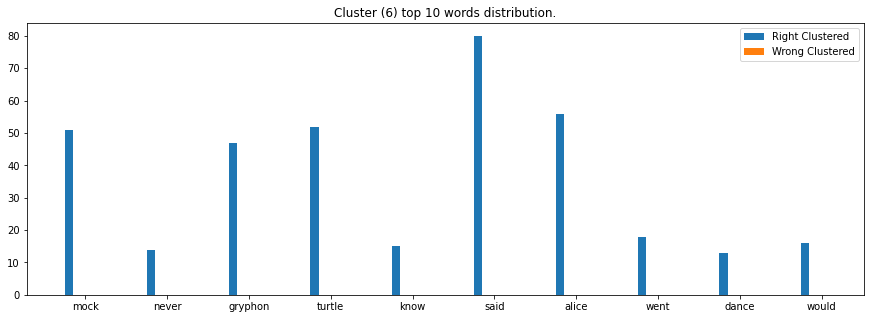

Top 10 words in the right clustered
 [('said', 80), ('alice', 56), ('turtle', 52), ('mock', 51), ('gryphon', 47), ('went', 18), ('would', 16), ('know', 15), ('never', 14), ('dance', 13)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




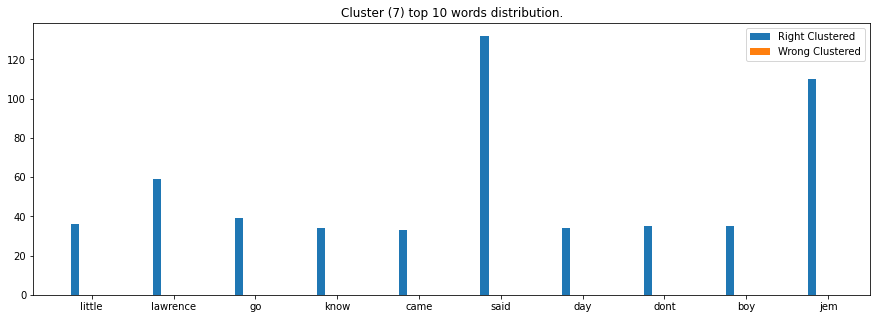

Top 10 words in the right clustered
 [('said', 132), ('jem', 110), ('lawrence', 59), ('go', 39), ('little', 36), ('boy', 35), ('dont', 35), ('know', 34), ('day', 34), ('came', 33)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




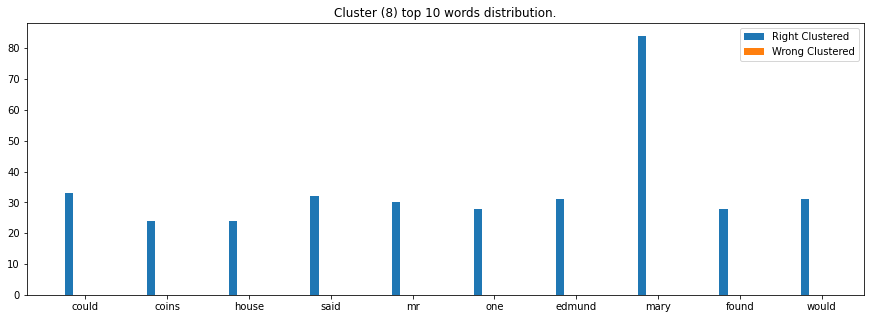

Top 10 words in the right clustered
 [('mary', 84), ('could', 33), ('said', 32), ('would', 31), ('edmund', 31), ('mr', 30), ('one', 28), ('found', 28), ('house', 24), ('coins', 24)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




In [ ]:
top_frequent_analysis(hc_tfidf.labels_,books_df.author,books_df.partition)

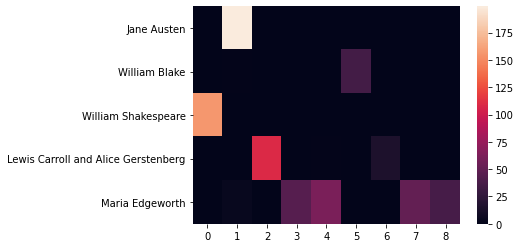

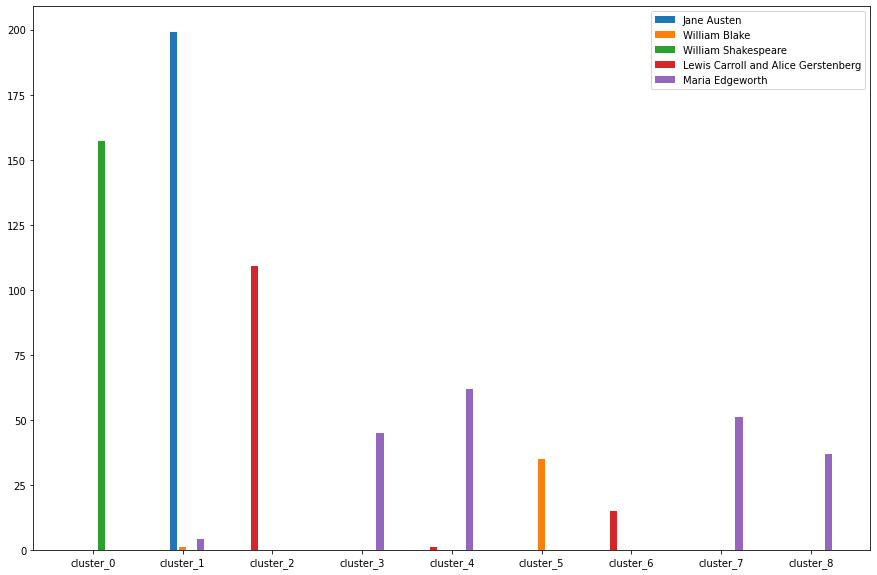

,0,1,2,3,4,5,6,7,8,label
0,0,199,0,0,0,0,0,0,0,Jane Austen
1,0,1,0,0,0,35,0,0,0,William Blake
2,157,0,0,0,0,0,0,0,0,William Shakespeare
3,0,0,109,0,1,0,15,0,0,Lewis Carroll and Alice Gerstenberg
4,0,4,0,45,62,0,0,51,37,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(hc_tfidf.labels_, books_df.author)

In [ ]:
labels_tfidf=map_actual_labels(hc_tfidf.labels_,books_df.author)
labels_BOW=map_actual_labels(hc_BOW.labels_,books_df.author)

In [ ]:
calculate_metrics(books_df.author,labels_tfidf,tfidf)

Homogeneity score:  0.97
Completeness score:  0.97
V-measure score:  0.97
Adjusted rand score:  0.98
Kappa score:  0.99
Silhouette score:  0.02
Correlation:  SpearmanrResult(correlation=0.9889112060337032, pvalue=0.0)


In [ ]:
get_clusters_label(hc_BOW.labels_ ,books_df.author)

actual_labels
clusters actual_labels                                     
0        Jane Austen                              96.984925
         Maria Edgeworth                           2.512563
         William Blake                             0.502513
1        Maria Edgeworth                          95.774648
         Lewis Carroll and Alice Gerstenberg       4.225352
2        Lewis Carroll and Alice Gerstenberg      90.000000
         Maria Edgeworth                           6.250000
         Jane Austen                               3.750000
3        Lewis Carroll and Alice Gerstenberg     100.000000
4        Maria Edgeworth                          97.520661
         Jane Austen                               2.479339
5        William Shakespeare                     100.000000
6        William Shakespeare                      98.058252
         Lewis Carroll and Alice Gerstenberg       0.970874
         Maria Edgeworth                           0.970874
7        William Blake                            94.594595
         Maria Edgeworth                           5.405405

In [ ]:
pd.DataFrame(evaluate_cluster_labels(get_clusters_label(hc_BOW.labels_ ,books_df.author)))

,cluster,label,percentage
0,0,Jane Austen,96.984925
1,1,Maria Edgeworth,95.774648
2,2,Lewis Carroll and Alice Gerstenberg,90.000000
3,3,Lewis Carroll and Alice Gerstenberg,100.000000
4,4,Maria Edgeworth,97.520661
5,5,William Shakespeare,100.000000
6,6,William Shakespeare,98.058252
7,7,William Blake,94.594595


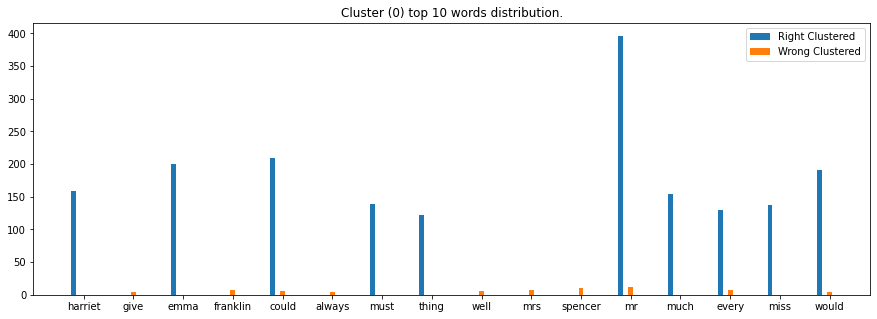

Top 10 words in the right clustered
 [('mr', 396), ('could', 209), ('emma', 200), ('would', 191), ('harriet', 159), ('much', 154), ('must', 139), ('miss', 137), ('every', 129), ('thing', 122)]

Top 10 words in the wrong clustered
 [('mr', 12), ('spencer', 10), ('every', 8), ('mrs', 8), ('franklin', 7), ('well', 6), ('could', 6), ('would', 5), ('give', 5), ('always', 5)]

Found 4 words in both right and wrong clustered top words [('mr', 12), ('every', 8), ('could', 6), ('would', 5)]




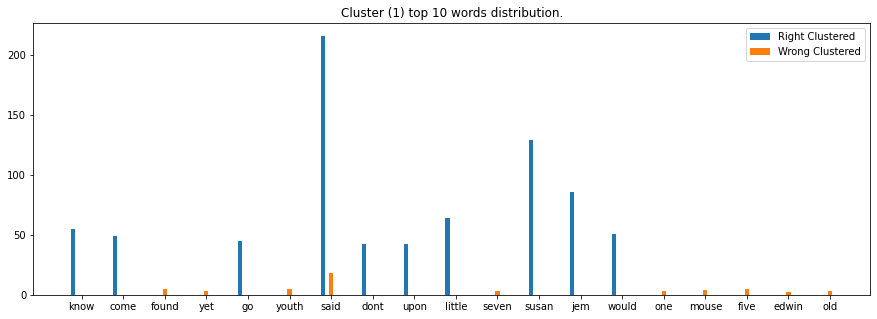

Top 10 words in the right clustered
 [('said', 216), ('susan', 129), ('jem', 86), ('little', 64), ('know', 55), ('would', 51), ('come', 49), ('go', 45), ('dont', 42), ('upon', 42)]

Top 10 words in the wrong clustered
 [('said', 18), ('found', 5), ('youth', 5), ('five', 5), ('mouse', 4), ('old', 3), ('yet', 3), ('one', 3), ('seven', 3), ('edwin', 2)]

Found 1 words in both right and wrong clustered top words [('said', 18)]




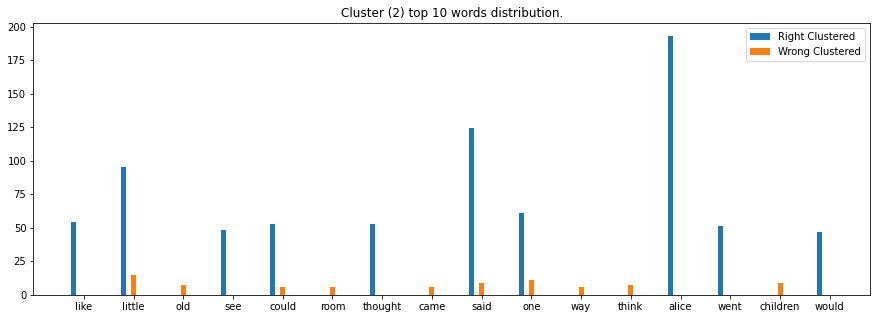

Top 10 words in the right clustered
 [('alice', 193), ('said', 124), ('little', 95), ('one', 61), ('like', 54), ('thought', 53), ('could', 53), ('went', 51), ('see', 48), ('would', 47)]

Top 10 words in the wrong clustered
 [('little', 15), ('one', 11), ('said', 9), ('children', 9), ('think', 7), ('old', 7), ('came', 6), ('way', 6), ('could', 6), ('room', 6)]

Found 4 words in both right and wrong clustered top words [('little', 15), ('one', 11), ('said', 9), ('could', 6)]




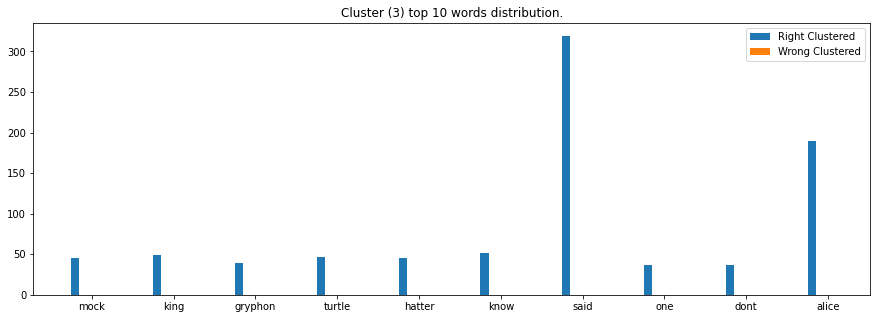

Top 10 words in the right clustered
 [('said', 319), ('alice', 189), ('know', 51), ('king', 49), ('turtle', 46), ('hatter', 45), ('mock', 45), ('gryphon', 39), ('dont', 37), ('one', 37)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




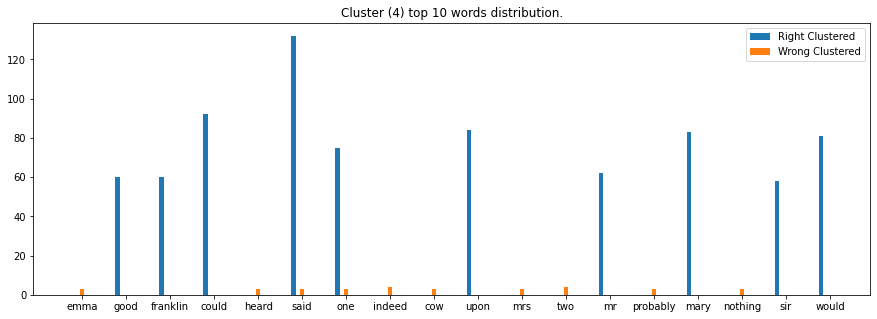

Top 10 words in the right clustered
 [('said', 132), ('could', 92), ('upon', 84), ('mary', 83), ('would', 81), ('one', 75), ('mr', 62), ('good', 60), ('franklin', 60), ('sir', 58)]

Top 10 words in the wrong clustered
 [('two', 4), ('indeed', 4), ('emma', 3), ('mrs', 3), ('one', 3), ('cow', 3), ('probably', 3), ('nothing', 3), ('said', 3), ('heard', 3)]

Found 2 words in both right and wrong clustered top words [('one', 3), ('said', 3)]




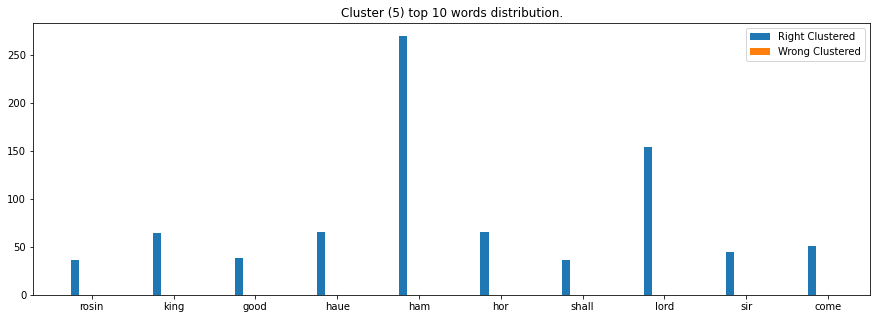

Top 10 words in the right clustered
 [('ham', 270), ('lord', 154), ('hor', 66), ('haue', 65), ('king', 64), ('come', 51), ('sir', 45), ('good', 38), ('shall', 36), ('rosin', 36)]

Top 10 words in the wrong clustered
 []

Found 0 words in both right and wrong clustered top words []




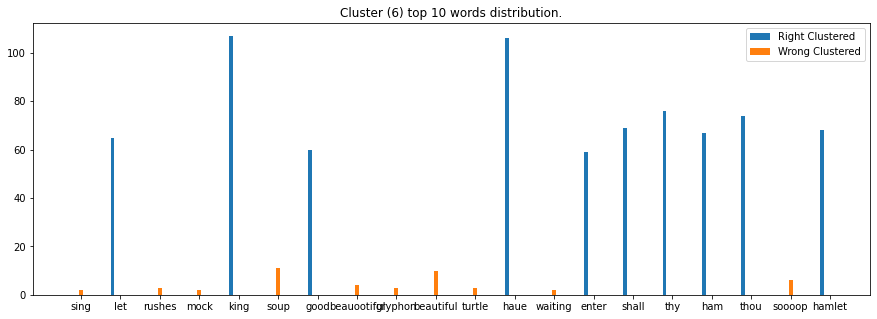

Top 10 words in the right clustered
 [('king', 107), ('haue', 106), ('thy', 76), ('thou', 74), ('shall', 69), ('hamlet', 68), ('ham', 67), ('let', 65), ('good', 60), ('enter', 59)]

Top 10 words in the wrong clustered
 [('soup', 11), ('beautiful', 10), ('soooop', 6), ('beauootiful', 4), ('gryphon', 3), ('turtle', 3), ('rushes', 3), ('sing', 2), ('mock', 2), ('waiting', 2)]

Found 0 words in both right and wrong clustered top words []




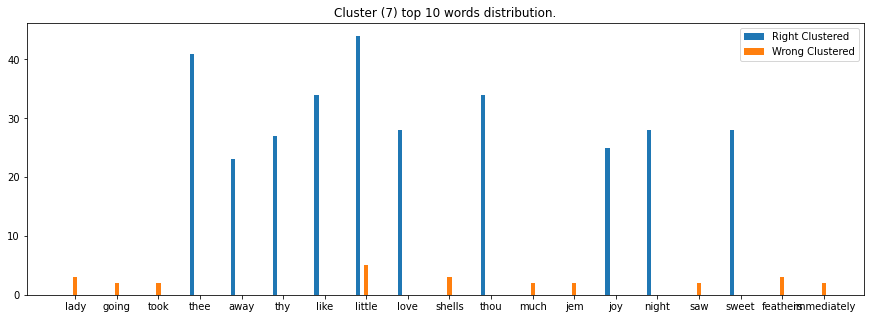

Top 10 words in the right clustered
 [('little', 44), ('thee', 41), ('like', 34), ('thou', 34), ('sweet', 28), ('love', 28), ('night', 28), ('thy', 27), ('joy', 25), ('away', 23)]

Top 10 words in the wrong clustered
 [('little', 5), ('shells', 3), ('lady', 3), ('feathers', 3), ('much', 2), ('took', 2), ('going', 2), ('saw', 2), ('immediately', 2), ('jem', 2)]

Found 1 words in both right and wrong clustered top words [('little', 5)]




In [ ]:
top_frequent_analysis(hc_BOW.labels_,books_df.author,books_df.partition)

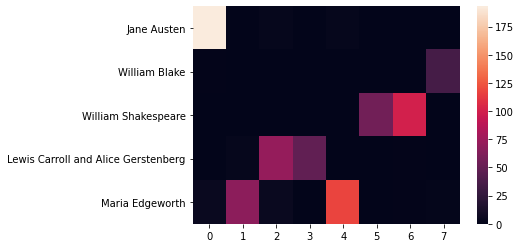

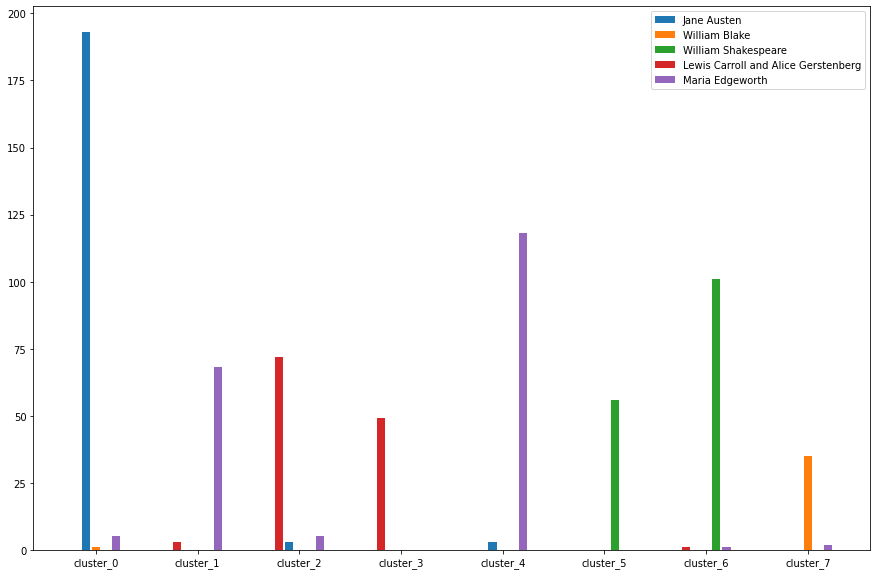

,0,1,2,3,4,5,6,7,label
0,193,0,3,0,3,0,0,0,Jane Austen
1,1,0,0,0,0,0,0,35,William Blake
2,0,0,0,0,0,56,101,0,William Shakespeare
3,0,3,72,49,0,0,1,0,Lewis Carroll and Alice Gerstenberg
4,5,68,5,0,118,0,1,2,Maria Edgeworth


In [ ]:
cluster_labels_dist_plot(hc_BOW.labels_, books_df.author)

In [ ]:
calculate_metrics(books_df.author,labels_BOW, bow)

Homogeneity score:  0.89
Completeness score:  0.89
V-measure score:  0.89
Adjusted rand score:  0.91
Kappa score:  0.97
Silhouette score:  0.02
Correlation:  SpearmanrResult(correlation=0.9733213942245061, pvalue=0.0)
